# **Kütüphanelerin Yüklenmesi**

In [33]:
# Gerekli kütüphaneleri yükleyelim
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import tensorflow as tf 
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import os
import kagglehub

# **Veri setinin yüklenmesi**

In [35]:
crowww_a_large_scale_fish_dataset_path = kagglehub.dataset_download('crowww/a-large-scale-fish-dataset')


directory = os.path.join(crowww_a_large_scale_fish_dataset_path, 'Fish_Dataset')
directory = Path(directory)

In [36]:
# Tüm .png uzantılı dosyaların yollarını bul ve bir listeye at
File_Paths = list(directory.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Dosya yollarından etiketleri çıkart (ikinci sondan bir önceki klasörün adı)
File_Paths = pd.Series(File_Paths, name='Filepath').astype(str)
Labels = pd.Series(Labels, name='Label')

# Dosya yolları ve etiketleri bir DataFrame'e dönüştür
image_df = pd.concat([File_Paths, Labels], axis=1)

# Etiketleri filtrele (son iki karakteri "GT" ile bitenleri at)
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [37]:
# DataFrame'i karıştır ve index'i sıfırla
image_df = image_df.sample(frac=1).reset_index(drop = True)

image_df.head()

,Filepath,Label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Gilt-Head Bream
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Shrimp
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Sea Bass
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Sea Bass
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Trout


# **Veri Ön İnceleme**

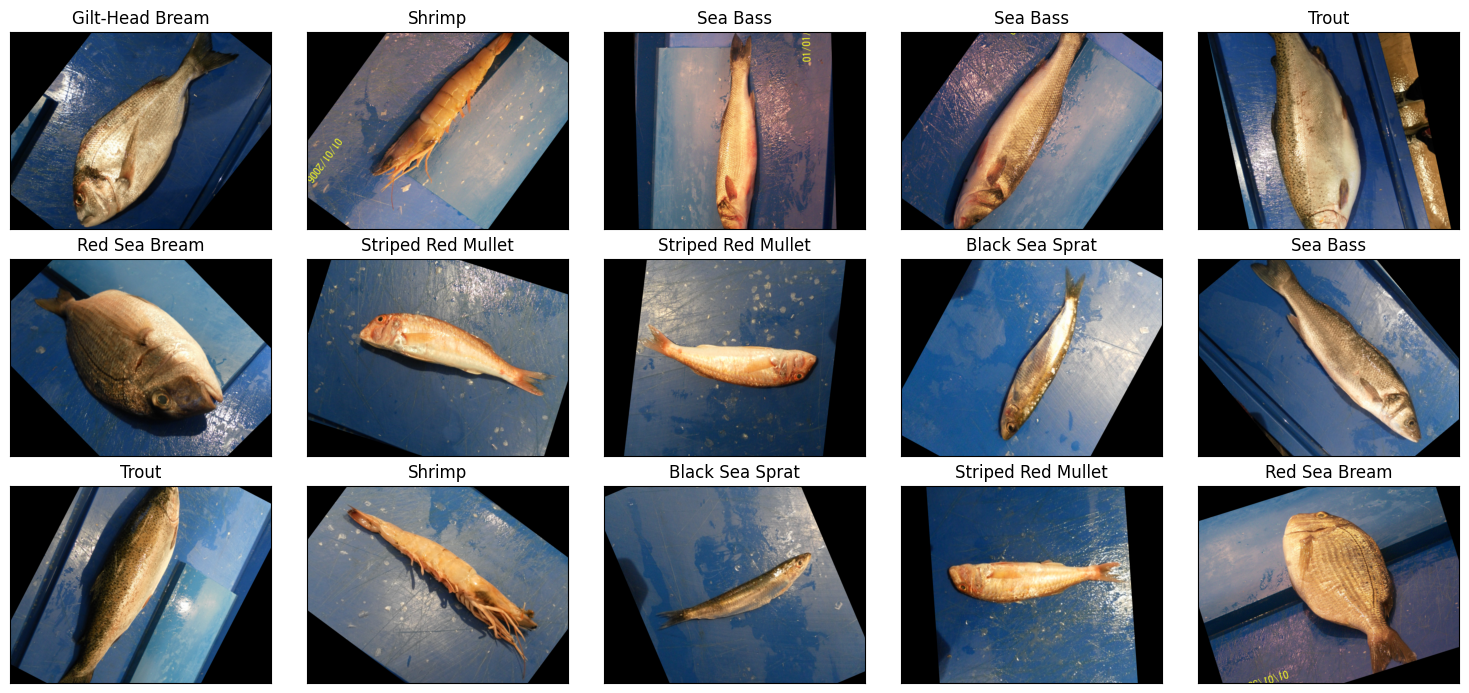

In [38]:
# Veri setindeki 25 resmi etiketleriyle birlikte göster

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

Red Mullet ve Striped Red Mullet balıkların rengi ve şekli birbirlerine benziyor. Renk dağılımlarını inceleyip rengin ayırt edici unsur olup olmadığına karar verelim. Webinar'da Mnist data seti için "gray scale" işlemi uygulanmıştı. Eğer renk ayırt edici bir unsursa bu işlemi uygulamayız.

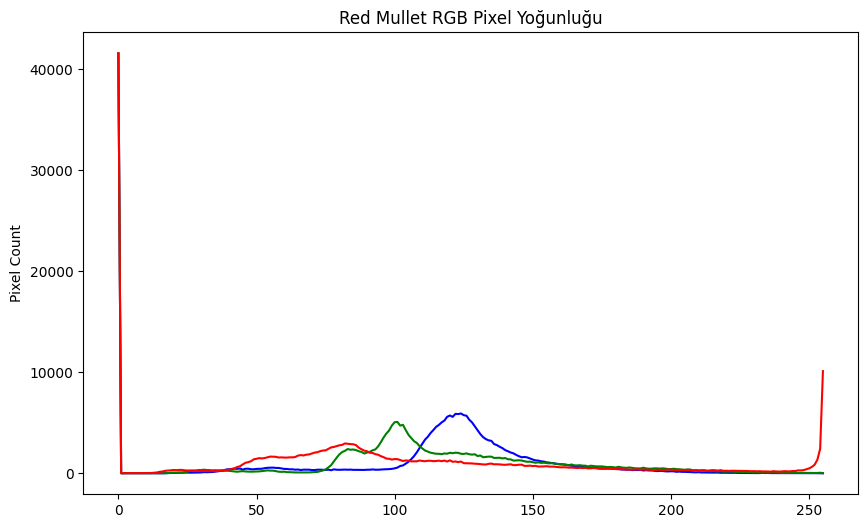

In [41]:
def display_rgb_histogram(image_df, selected_label):
    """Belirli bir balık türü için RGB piksel yoğunluğu histogramını görüntüler.

    Args:
        image_df: Görüntü dosya yollarını ve etiketlerini içeren Pandas DataFrame.
        selected_label: Histogramın görüntüleneceği balık türünün etiketi.
    """

    # Dosya yollarını ve etiketleri al
    path = image_df['Filepath'].tolist()
    label = image_df['Label'].tolist()

    # Belirtilen balık türüne ait rastgele bir görüntü seç
    img_path = random.choice([p for p, l in zip(path, label) if l == selected_label])

    # Görüntüyü renkli olarak oku
    img = cv2.imread(img_path)

    # Histogramı oluştur ve göster
    colors = ('b', 'g', 'r')  # OpenCV'de BGR sıralaması
    plt.figure(figsize=(10, 6))

    # Her renk kanalı için histogram hesapla ve çiz
    for i, color in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)

    # Başlık ve eksen etiketlerini ayarla
    plt.title(f'{selected_label} RGB Pixel Yoğunluğu')
    plt.ylabel('Pixel Count')
    
    # Histogramı göster
    plt.show()

# Red Mullet:
selected_label_1 = 'Red Mullet'
display_rgb_histogram(image_df, selected_label_1)


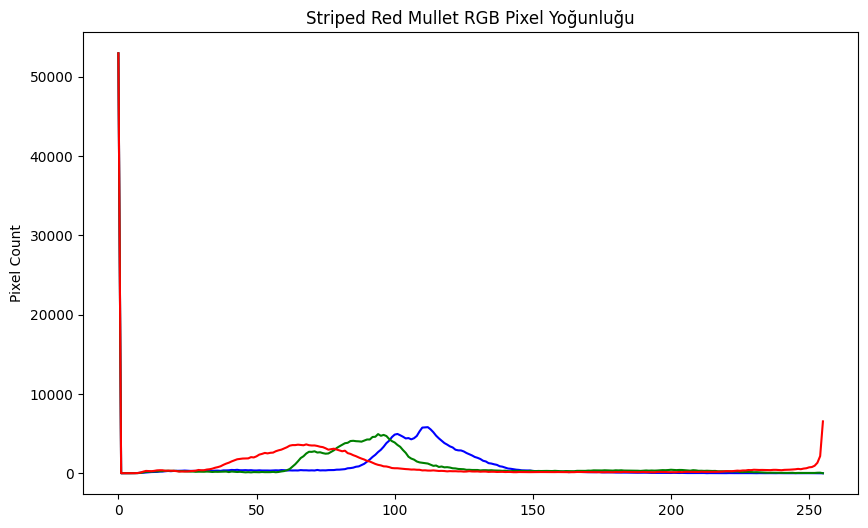

In [42]:
# Striped Red Mullet balığını incele:
selected_label_1 = 'Striped Red Mullet'
display_rgb_histogram(image_df, selected_label_1)

Bence renk faktörü veri seti için ayırt edici bir unsur bu yüzden "gray scale" işlemini uygulamayacağım.

# **Modelin Oluşturulması**

In [43]:
# Eğitim verileri için %90 oranında ayır
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)


In [12]:
# Veri setinin train ve test split işlemi:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)


In [44]:
# Verileri modelimiz için uygun hale getirelim

# Bu bir ANN projesi ancak mobilenet_v2 (CNN algoritmalarında genelde kullanılan) işlemi yaptığımda daha yüksek doğruluk skoru aldım. %88'den %93'e çıktı.
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


In [46]:
# Eğitim verilerini veri çerçevesinden (dataframe) yükleyerek bir veri akışı (flow) oluşturur.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,  # Eğitim verilerini içeren dataframe
    x_col='Filepath',  # Görüntü dosyalarının yolunu içeren sütun
    y_col='Label',  # Etiketleri içeren sütun
    target_size=(224, 224),  # Görüntü boyutunu belirtir
    color_mode='rgb',  # Görüntü renk modunu belirtir
    class_mode='categorical',  # Sınıflandırma problemi için kategorik etiketleri kullanır
    batch_size=128,  # Her batcht'e işlenecek örnek sayısını belirtir
    shuffle=True,  # Verileri karıştırır
    seed=42,  # Rastgele karıştırma için tohum değeri belirtir
    subset='training'  # Bu flow, eğitim verileri için kullanılacağını belirtir
)

# Doğrulama verilerini veri çerçevesinden (dataframe) yükleyerek bir veri akışı (flow) oluşturur.
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,  # Eğitim verilerini içeren dataframe
    x_col='Filepath',  # Görüntü dosyalarının yolunu içeren sütun
    y_col='Label',  # Etiketleri içeren sütun
    target_size=(224, 224),  # Görüntü boyutunu belirtir
    color_mode='rgb',  # Görüntü renk modunu belirtir
    class_mode='categorical',  # Sınıflandırma problemi için kategorik etiketleri kullanır
    batch_size=128,  # Her batchta işlenecek örnek sayısını belirtir
    shuffle=True,  # Verileri karıştırır
    seed=42,  # Rastgele karıştırma için tohum değeri belirtir
    subset='validation'  # Bu flow, doğrulama verileri için kullanılacağını belirtir
)

# Test verilerini veri çerçevesinden (dataframe) yükleyerek bir veri akışı (flow) oluşturur.
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,  # Test verilerini içeren dataframe
    x_col='Filepath',  # Görüntü dosyalarının yolunu içeren sütun
    y_col='Label',  # Etiketleri içeren sütun
    target_size=(224, 224),  # Görüntü boyutunu belirtir
    color_mode='rgb',  # Görüntü renk modunu belirtir
    class_mode='categorical',  # Sınıflandırma problemi için kategorik etiketleri kullanır
    batch_size=128,  # Her batchta işlenecek örnek sayısını belirtir
    shuffle=False  # Test verileri karıştırılmaz
)

Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [47]:
# Model için input katmanını :
import tensorflow as tf
model = tf.keras.Sequential()

# Giriş katmanı (224x224 boyutunda RGB görüntü)
inputs = tf.keras.Input(shape=(224, 224, 3))  # Girdi katmanı, 224x224 boyutunda RGB görüntü

# Girişi Flatten yaparak vektör haline getiriyoruz
x = tf.keras.layers.Flatten()(inputs)

In [48]:
# 3 tane Hidden Layer ekle:
x = tf.keras.layers.Dense(256, activation='relu')(x)
model.add(tf.keras.layers.Dropout(0.1))

x = tf.keras.layers.Dense(256, activation='relu')(x)
model.add(tf.keras.layers.Dropout(0.1))

x = tf.keras.layers.Dense(256, activation='relu')(x)
model.add(tf.keras.layers.Dropout(0.1))


In [49]:
# Output katmanı:
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

# Modeli tanımlıyoruz
model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [51]:
# Modelin derlenmesi
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate = 0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



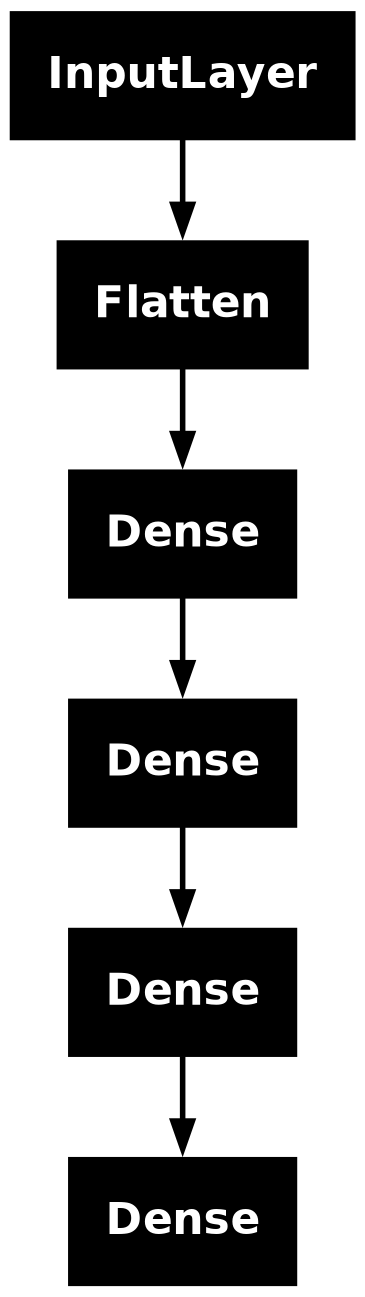

In [52]:
# Model mimarisini görselleştirme
tf.keras.utils.plot_model(model)

In [53]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,669,321 (147.51 MB)

 Trainable params: 38,669,321 (147.51 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Modelin eğitimi
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729799661.800791    1113 service.cc:145] XLA service 0x7bc738004c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729799661.800845    1113 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729799661.800851    1113 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/51 ━━━━━━━━━━━━━━━━━━━━ 19:15 23s/step - accuracy: 0.0859 - loss: 2.2367

I0000 00:00:1729799664.212307    1113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.2271 - loss: 17.4690 - val_accuracy: 0.5599 - val_loss: 1.6184
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.6651 - loss: 1.0670 - val_accuracy: 0.7636 - val_loss: 0.7377
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8150 - loss: 0.5467 - val_accuracy: 0.8210 - val_loss: 0.5373
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8908 - loss: 0.3370 - val_accuracy: 0.8722 - val_loss: 0.3959
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9465 - loss: 0.1905 - val_accuracy: 0.8704 - val_loss: 0.3759
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9638 - loss: 0.1349 - val_accuracy: 0.8747 - val_loss: 0.3610
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9661 - loss: 0.1138 - val_accuracy: 0.8889 - val_loss: 0.3152
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9859 - loss: 0.0696 - val_accuracy: 0.9167 - val_loss: 0.2550
E

# **Modelin Sonuçlarının İncelenmesi**

In [55]:
# 'history' nesnesinden eğitim sürecinin geçmişini DataFrame'e dönüştür
history_df=pd.DataFrame(history.history)
history_df

,accuracy,loss,val_accuracy,val_loss
0,0.352778,9.558827,0.559877,1.618429
1,0.705710,0.903416,0.763580,0.737750
2,0.822068,0.527304,0.820988,0.537274
3,0.900463,0.304343,0.872222,0.395879
4,0.938117,0.201863,0.870370,0.375934
5,0.964043,0.129844,0.874691,0.360959
6,0.965278,0.117486,0.888889,0.315161
7,0.987500,0.063856,0.916667,0.254968
8,0.995216,0.033544,0.925926,0.213946
9,0.999074,0.018276,0.925309,0.214435


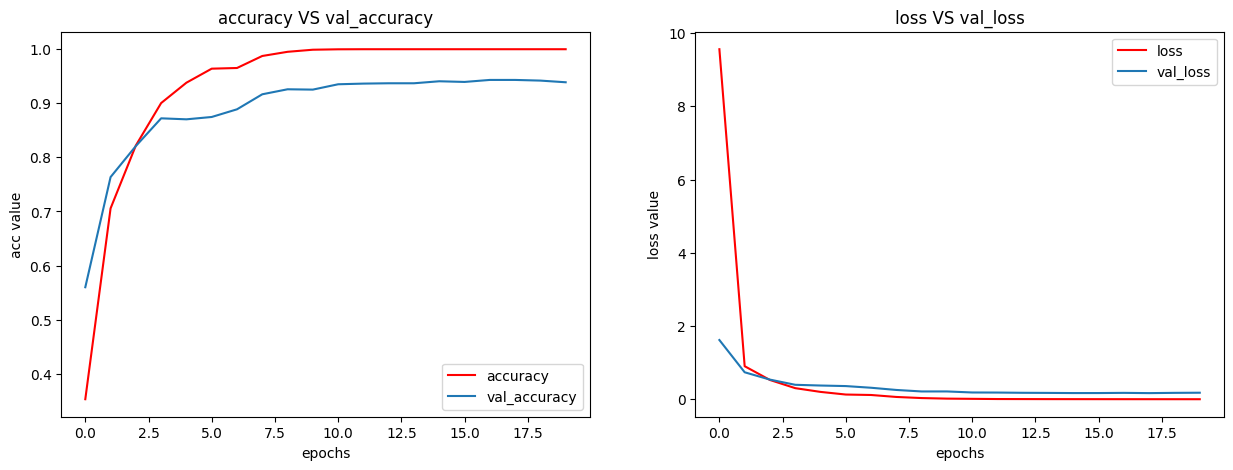

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))



# Accuracy ve val_accuracy skorlarını grafik üzerinde gözlemleyerek yorumla:
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()
# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()

In [57]:
# Test verileri üzerinde modeli değerlendir
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


    Test Loss: 0.17117
Test Accuracy: 95.11%


In [58]:
# Test resimlerini tahmin et:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Etiketleri eşle
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# sonuçları göster:
print(f'The first 5 predictions: {pred[:5]}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
The first 5 predictions: ['Striped Red Mullet', 'Hourse Mackerel', 'Gilt-Head Bream', 'Gilt-Head Bream', 'Hourse Mackerel']


In [59]:
# 'classification_report' fonksiyonunu sklearn'den içe aktar
from sklearn.metrics import classification_report

# Test veri kümesindeki gerçek etiketleri bir listeye al
y_test = list(test_df.Label)

# Gerçek etiketler (y_test) ve tahmin edilen etiketler (pred) ile sınıflandırma raporunu yazdır
print(classification_report(y_test, pred))

# Test görüntülerinin gerçek sınıf etiketlerini al
y_true = test_images.classes


                    precision    recall  f1-score   support

   Black Sea Sprat       0.94      0.97      0.95       105
   Gilt-Head Bream       0.92      0.89      0.90        98
   Hourse Mackerel       0.96      0.97      0.97       102
        Red Mullet       0.98      0.95      0.96        85
     Red Sea Bream       0.98      0.99      0.98        93
          Sea Bass       0.92      0.91      0.91       106
            Shrimp       0.98      0.98      0.98       120
Striped Red Mullet       0.92      0.98      0.95        89
             Trout       0.97      0.92      0.94       102

          accuracy                           0.95       900
         macro avg       0.95      0.95      0.95       900
      weighted avg       0.95      0.95      0.95       900



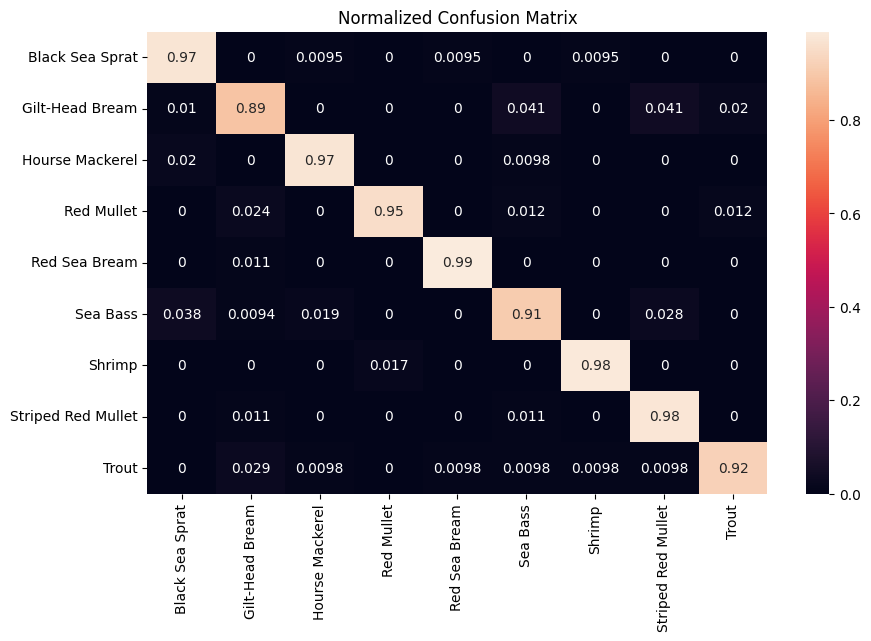

In [60]:
# 'confusion_matrix' fonksiyonunu sklearn'den ve 'seaborn' kütüphanesini içe aktar
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Gerçek etiketler (y_test) ve tahmin edilen etiketler (pred) ile normalize edilmiş karışıklık matrisini oluştur
cf_matrix = confusion_matrix(y_test, pred, normalize='true')

# Karışıklık matrisini görselleştirmek için bir figür oluştur
plt.figure(figsize=(10, 6))

# Normalize edilmiş karışıklık matrisini ısı haritası (heatmap) olarak göster
sns.heatmap(cf_matrix, annot=True, xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))

# Grafiğe başlık ekle
plt.title('Normalized Confusion Matrix')

# Grafiği göster
plt.show()


In [ ]:
# Veri kümesinden etiketleri ile birlikte 25 adet farklı balık resmi göster
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

# 5x5 alt grafikler üzerinde döngü oluştur
for i, ax in enumerate(axes.flat):
    # Test verisindeki görüntüyü oku ve göster; başlangıç indeksini 25 olarak ayarla
    ax.imshow(plt.imread(test_df.Filepath.iloc[i + 25]))  # Başlangıç indeksini değiştirin
    
    # Gerçek etiket (True) ve tahmin edilen etiket (Predicted) ile başlık ayarla
    ax.set_title(f"True: {test_df.Label.iloc[i + 25]}\nPredicted: {pred[i + 25]}")  # Başlangıç indeksini değiştirin

# Alt grafikler arasındaki boşluğu sıkılaştır
plt.tight_layout()

# Grafiği göster
plt.show()
